# Import the necessary libraries.

In [1]:
# Built-in packages
import json
import warnings
warnings.filterwarnings("ignore")

# Third party packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import iplot

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Charting options
sns.set(context= "notebook", color_codes=True)
plt.style.use('bmh')
# Set notebook mode to work in offline
pyo.init_notebook_mode()
%matplotlib inline 

# !pip install uszipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True) 

with open(f"./region_county.json", "r") as f:
    region_county = json.loads(f.read())

## Read the data as a data frame

In [2]:
# Read the CSV file and display first 10 rows
df = pd.read_csv("./Bank_Personal_Loan_Modelling.csv")
df.columns = [i.replace(" ", "_").lower() for i in df.columns]
df.head(10)

id  age  experience  income  zip_code  family  ccavg  education  mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   
5   6   37          13      29     92121       4    0.4          2       155   
6   7   53          27      72     91711       2    1.5          2         0   
7   8   50          24      22     93943       1    0.3          3         0   
8   9   35          10      81     90089       3    0.6          2       104   
9  10   34           9     180     93023       1    8.9          3         0   

   personal_loan  securities_account  cd_account  online  creditcard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  
5              0                   0           0       1           0  
6              0                   0           0       1           0  
7              0                   0           0       0           1  
8              0                   0           0       1           0  
9              1                   0           0       0           0

<hr>

- **id** : Customer ID
- **age** : Customer's age in completed years
- **experience** : years of professional experience
- **income** : Annual income of the customer
- **zip_code** : Home Address ZIP code.
- **family** : Family size of the customer
- **ccavg** : Avg. spending on credit cards per month
- **education** : Education Level.
    - Undergrad
    - Graduate
    - Advanced/Professional
- **mortgage** : Value of house mortgage if any. 
- **personal_loan** : Did this customer accept the personal loan offered in the last campaign?
- **securities_account** : Does the customer have a securities account with the bank?
- **cd_account** : Does the customer have a certificate of deposit (CD) account with the bank?
- **online** : Does the customer use internet banking facilities?
- **creditcard** : Does the customer use a credit card issued by UniversalBank?

<hr>

# Exploratory Data Analysis (EDA)

In [3]:
print(f"The shape of the DatFrame is: {df.shape}, which means there are {df.shape[0]} rows and {df.shape[1]} columns.")

The shape of the DatFrame is: (5000, 14), which means there are 5000 rows and 14 columns.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
id                    5000 non-null int64
age                   5000 non-null int64
experience            5000 non-null int64
income                5000 non-null int64
zip_code              5000 non-null int64
family                5000 non-null int64
ccavg                 5000 non-null float64
education             5000 non-null int64
mortgage              5000 non-null int64
personal_loan         5000 non-null int64
securities_account    5000 non-null int64
cd_account            5000 non-null int64
online                5000 non-null int64
creditcard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


We have **13 integer** columns, **1 float** column out of which **personal_loan**, **securities_account**, **cd_account**, **online**, **creditcard** have binary values.

The column **personal_loan** is our target variable.

<hr>

In [5]:
# Check if any of the columns have null values
print(df.isnull().sum())

id                    0
age                   0
experience            0
income                0
zip_code              0
family                0
ccavg                 0
education             0
mortgage              0
personal_loan         0
securities_account    0
cd_account            0
online                0
creditcard            0
dtype: int64


***There are no null values in any of the columns.***

<hr>

In [6]:
df_summary = df.describe()
df.describe()

id          age   experience       income      zip_code  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean   2500.500000    45.338400    20.104600    73.774200  93152.503000   
std    1443.520003    11.463166    11.467954    46.033729   2121.852197   
min       1.000000    23.000000    -3.000000     8.000000   9307.000000   
25%    1250.750000    35.000000    10.000000    39.000000  91911.000000   
50%    2500.500000    45.000000    20.000000    64.000000  93437.000000   
75%    3750.250000    55.000000    30.000000    98.000000  94608.000000   
max    5000.000000    67.000000    43.000000   224.000000  96651.000000   

            family        ccavg    education     mortgage  personal_loan  \
count  5000.000000  5000.000000  5000.000000  5000.000000    5000.000000   
mean      2.396400     1.937938     1.881000    56.498800       0.096000   
std       1.147663     1.747659     0.839869   101.713802       0.294621   
min       1.000000     0.000000     1.000000     0.000000       0.000000   
25%       1.000000     0.700000     1.000000     0.000000       0.000000   
50%       2.000000     1.500000     2.000000     0.000000       0.000000   
75%       3.000000     2.500000     3.000000   101.000000       0.000000   
max       4.000000    10.000000     3.000000   635.000000       1.000000   

       securities_account  cd_account       online   creditcard  
count         5000.000000  5000.00000  5000.000000  5000.000000  
mean             0.104400     0.06040     0.596800     0.294000  
std              0.305809     0.23825     0.490589     0.455637  
min              0.000000     0.00000     0.000000     0.000000  
25%              0.000000     0.00000     0.000000     0.000000  
50%              0.000000     0.00000     1.000000     0.000000  
75%              0.000000     0.00000     1.000000     1.000000  
max              1.000000     1.00000     1.000000     1.000000

**Observations :**

- The **age** column has a range of 23 to 67 years old. The mean age is 45 years old.
- The **experience** column has a min value of **-3** and it is possible that there are many such values which need to be handled. But has a average value of 20 years of experience. (Further in our exploration, we will find that **experience** has a high correlation to **age** and will be dropping this column so we don't necessarily have to handle negative values).
- The average **income** is **73.7** and the max value is **more than 3x** of the average **income** of **224.0**.
- The rest of columns don't tell us much about the data. We will explore them in depth in the following sections.

<hr>

### Plotting charts for distribution of all columns

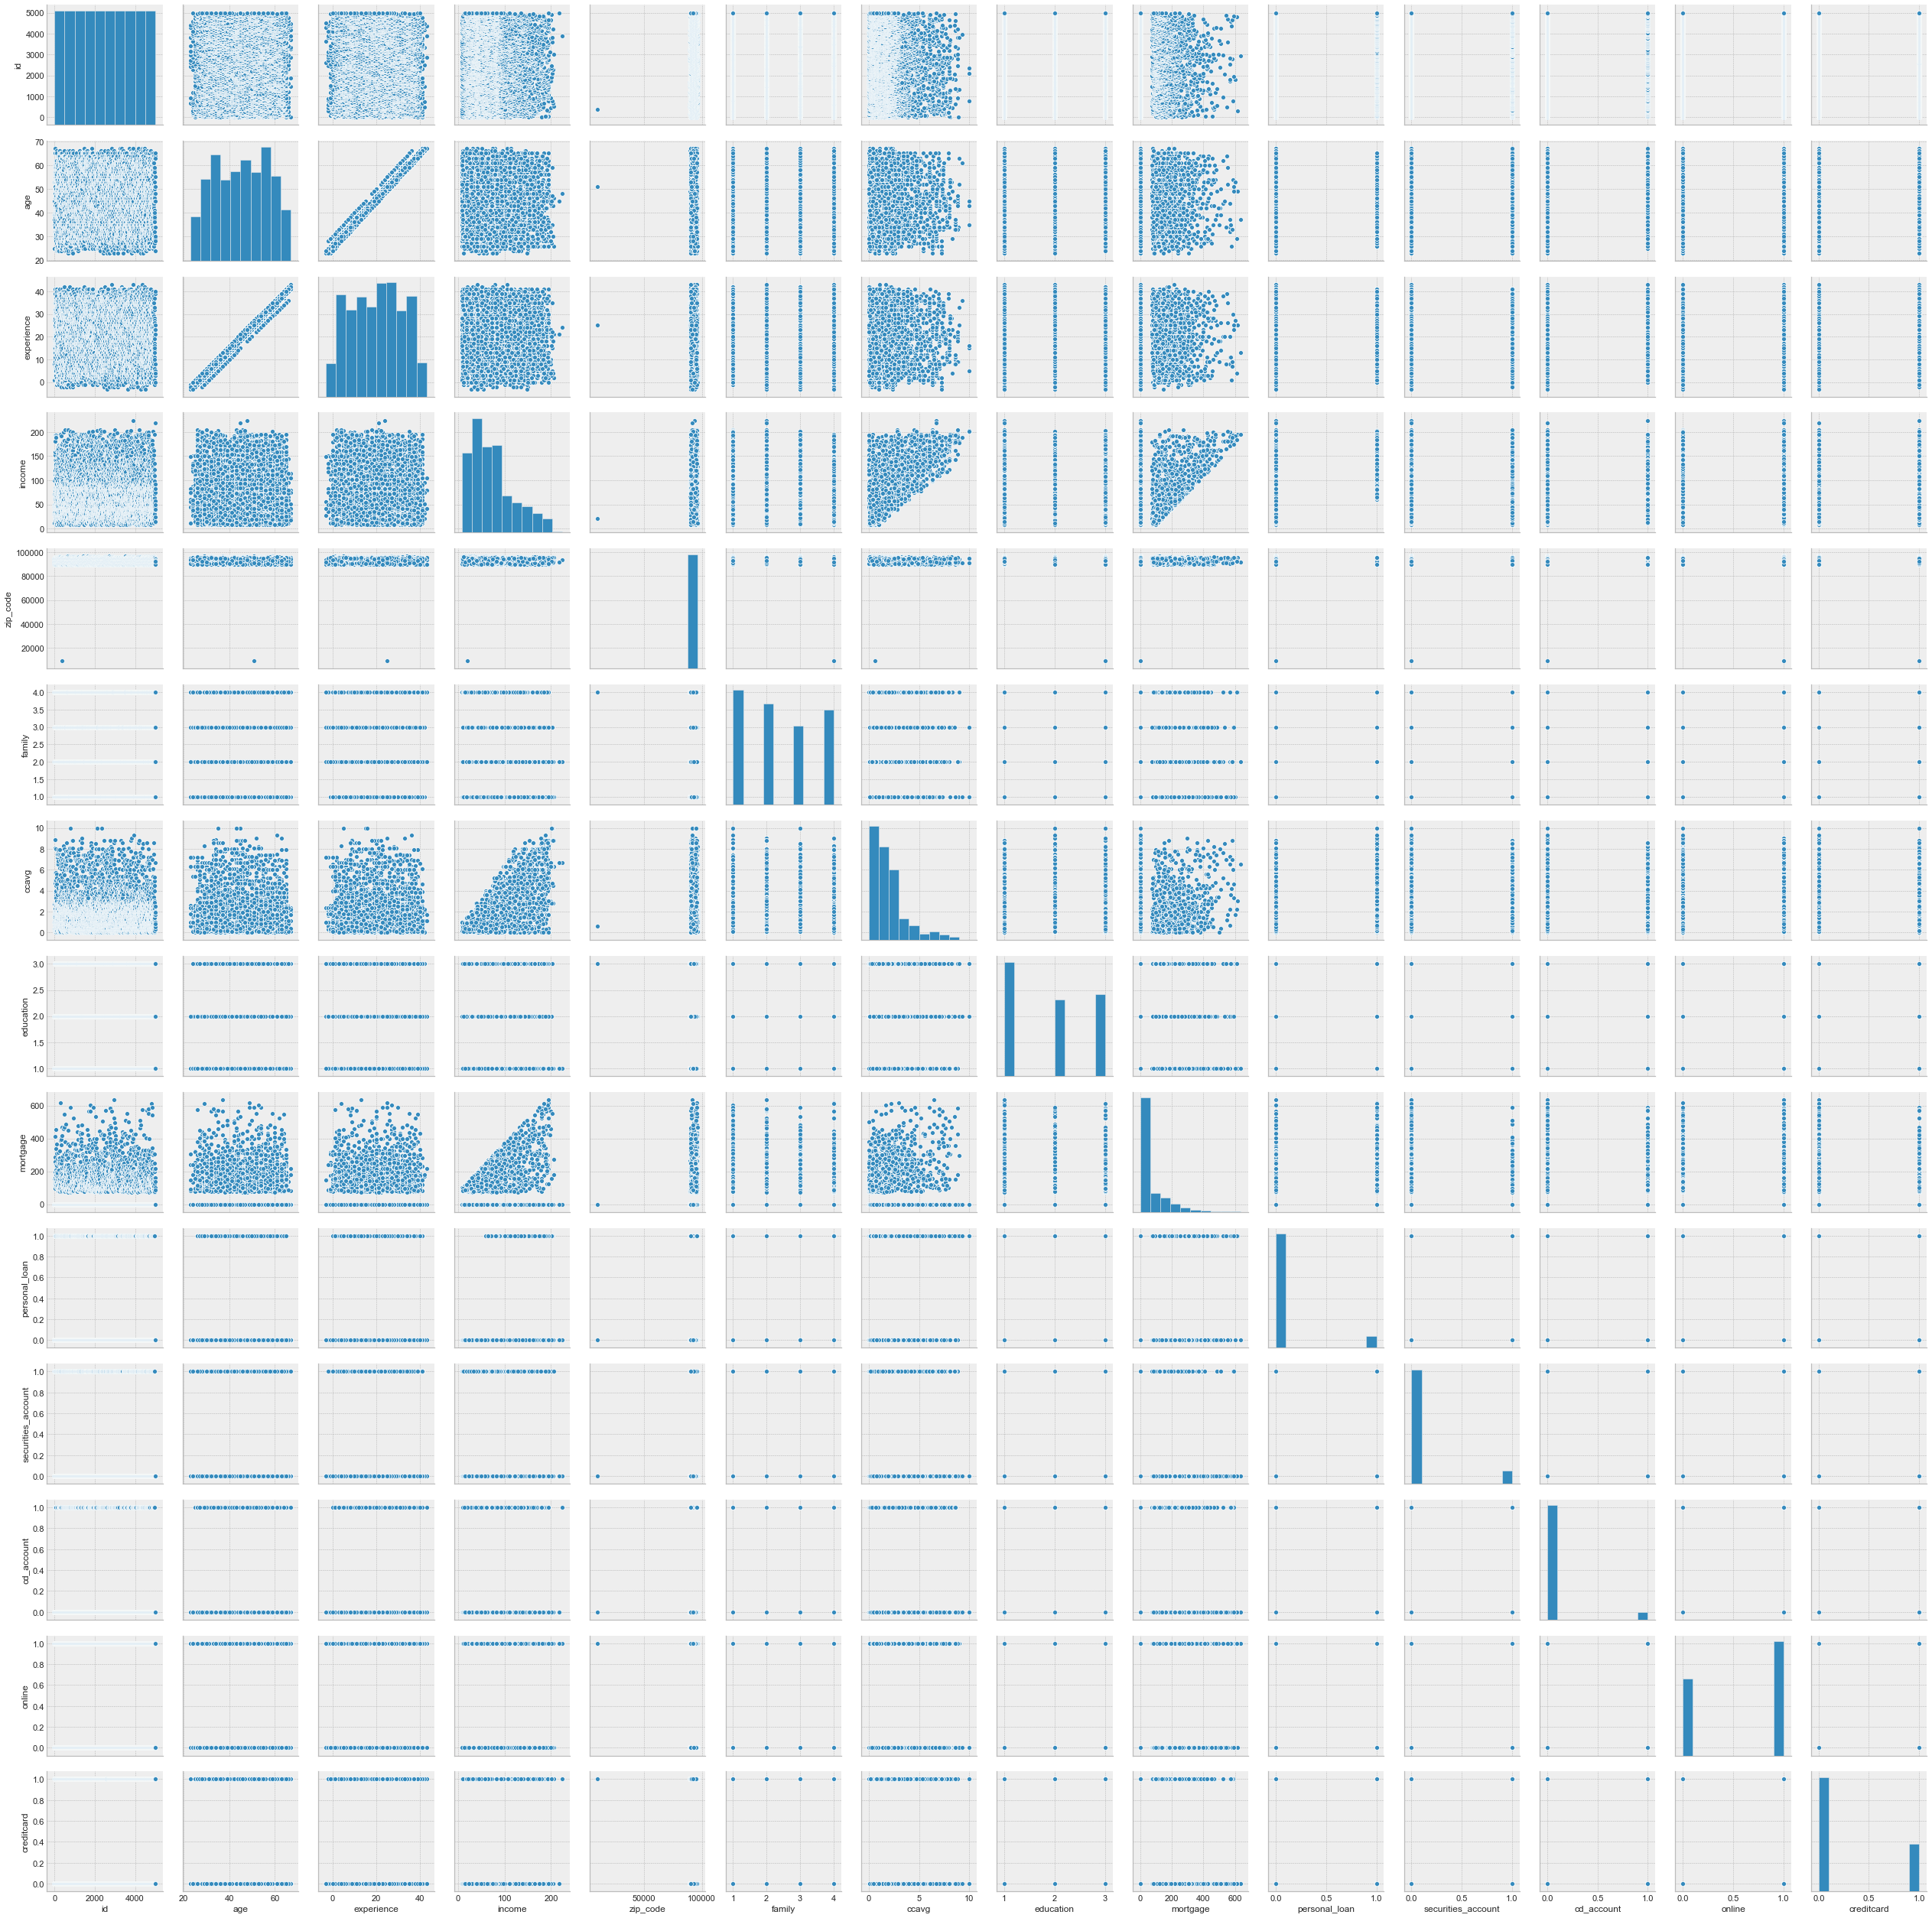

In [7]:
sns.pairplot(df);

**Observations:**

- Looking at the above plots, we can say that the average credit card **ccavg** spend and the **mortgage** increase as the income increases.
- The columns **age** and **experience** have a very linear relationship.

<hr>

Let's do an in-depth exploration for all the other columns.

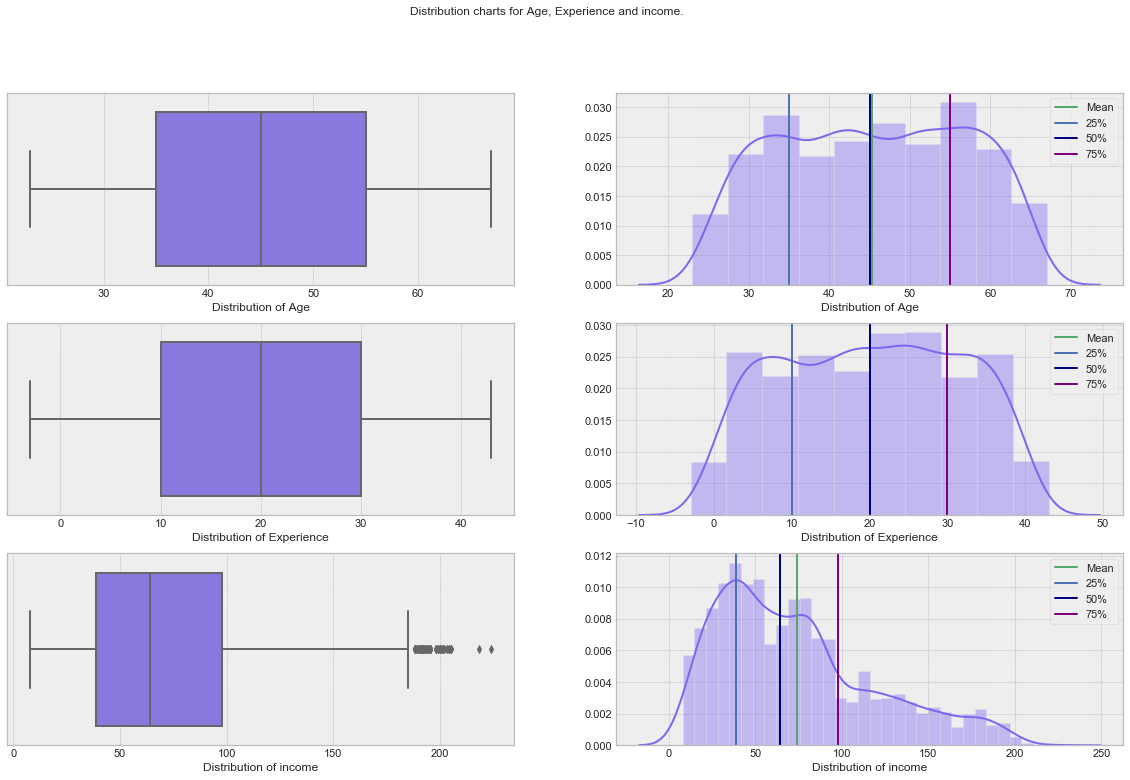

In [8]:
def draw_axvlines(plt, col):
    mean = df_summary.loc["mean", col]
    q1 = df_summary.loc["25%", col]
    q2 = df_summary.loc["50%", col]
    q3 = df_summary.loc["75%", col]
    plt.axvline(mean, color = "g");              # Plotting a line to mark the mean 
    plt.axvline(q1, color = "b");                # Plotting a line to mark Q1 
    plt.axvline(q2, color = "navy");             # Plotting a line to mark Q2 
    plt.axvline(q3, color = "purple");           # Plotting a line to mark Q3
    plt.legend({"Mean": mean, "25%" : q1, "50%" : q2, "75%" : q3});

fig, axes = plt.subplots(3, 2, figsize = (20,12));
fig.suptitle('Distribution charts for Age, Experience and income.');


# Create boxplot and histogram to show distribution of Age
sns.boxplot(df["age"], ax = axes[0][0], color = "mediumslateblue");
axes[0][0].set(xlabel = 'Distribution of Age');

pp = sns.distplot(df["age"], ax = axes[0][1], bins = 10, color = "mediumslateblue");
axes[0][1].set(xlabel = 'Distribution of Age');
draw_axvlines(pp, "age");


# Create boxplot and histogram to show distribution of Experience
sns.boxplot(df["experience"], ax = axes[1][0], color = "mediumslateblue");
axes[1][0].set(xlabel = 'Distribution of Experience');

pp = sns.distplot(df["experience"], ax = axes[1][1], bins = 10, color = "mediumslateblue");
axes[1][1].set(xlabel = 'Distribution of Experience');
draw_axvlines(pp, "experience")


# Create boxplot and histogram to show distribution of Income
sns.boxplot(df["income"], ax = axes[2][0], color = "mediumslateblue");
axes[2][0].set(xlabel = 'Distribution of income');

pp = sns.distplot(df["income"], ax = axes[2][1], color = "mediumslateblue");
axes[2][1].set(xlabel = 'Distribution of income');
draw_axvlines(pp, "income")

**Observations:**

- **Age**: 
  - The box plot shows that it is very evenly distributed around the mean and there are no outliers. 
  - The histogram shows that there is a symmetric distribution and the mean and Q2 is almost the same.
  - There are a few peaks at Q1, Q2 and Q3.

- **Experience**: 
  - The distribution is verry similar to that of Age.
  - The mean and Q2 is the same. Has a symmetric distribution.

- **Income**: 
  - The boxplot shows a few outliers beyond the upper whisker.
  - The histogram indicates that the distribution is right-skewed.

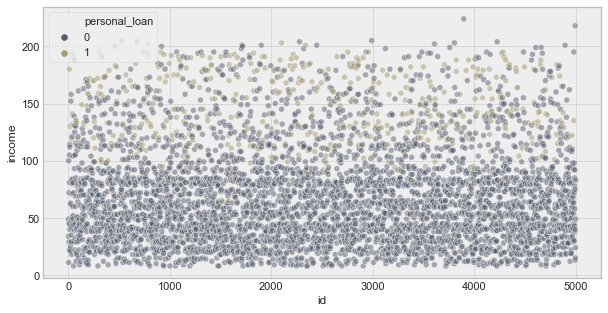

In [9]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = "id", y = "income", data=df, hue = "personal_loan", palette="cividis", alpha = 0.5);

- Plotting a scatterplot for all customers **id** by their **income**, we can see that people that do not have a **personal_loan** tend to be in the lower half of **income** scale.

In [10]:
# A function that returns value counts for a column split by personal_loan
def groupby_get_cc_count(tdf, col):
    tdf = tdf.groupby([col, "personal_loan"])["personal_loan"].count().reset_index(level = 0)
    tdf.columns = [col, "count"]
    tdf = tdf.reset_index()
    return tdf

In [11]:
fig, axes = plt.subplots(1,1, figsize=(20, 5))

# Function to create a donut chart.
def create_donut(*args):
    plt.subplot(1, 2, args[0])
    if len(args) == 6:
        size = [args[1], args[2], args[3], args[4]]
        names = [f'Family of 1 \n {args[1]}%', f'Family of 2 \n {args[2]}%', f'Family of 3 \n {args[3]}%', f'Family of 4 \n {args[4]}%']          # Add annotations
    else:
        size = [args[1], args[2]]
        names = [f'Personal loan - 0 \n {args[1]}%', f'Personal loan - 1 \n {args[2]}%']
    plt.pie(size, labels=names)     # Create a pie chart

xx = df["family"].value_counts().reset_index()
xx["index"] = xx["index"].astype(str)
xx["family_perc"] = xx["family"].apply(lambda x : round((x/5000)*100, 2))
create_donut(*(1, xx.iloc[0]["family_perc"], xx.iloc[1]["family_perc"], xx.iloc[2]["family_perc"], xx.iloc[3]["family_perc"], 4))      # Create a donut chart each family size


# Create a bar chart showing count of family grouped by size and split by personal_loan
plt.subplot(1, 2, 2)
xx = groupby_get_cc_count(df[["family", "personal_loan"]], "family")
sns.barplot(xx["family"], xx["count"], hue = xx["personal_loan"], palette = ["skyblue", "darkgreen"]);
plt.show();

**Observations:**

- It is visible from the pie chart that the number of families with a size of 1 (29.44%) are more followed by families with size of 2 (25.92%).
- Grouping it by **personal_loan** shows that the number of personal loans taken by a **family of 4** is the highest. There is an interesting pattern that shows larger families feel a need to get personal loans more.

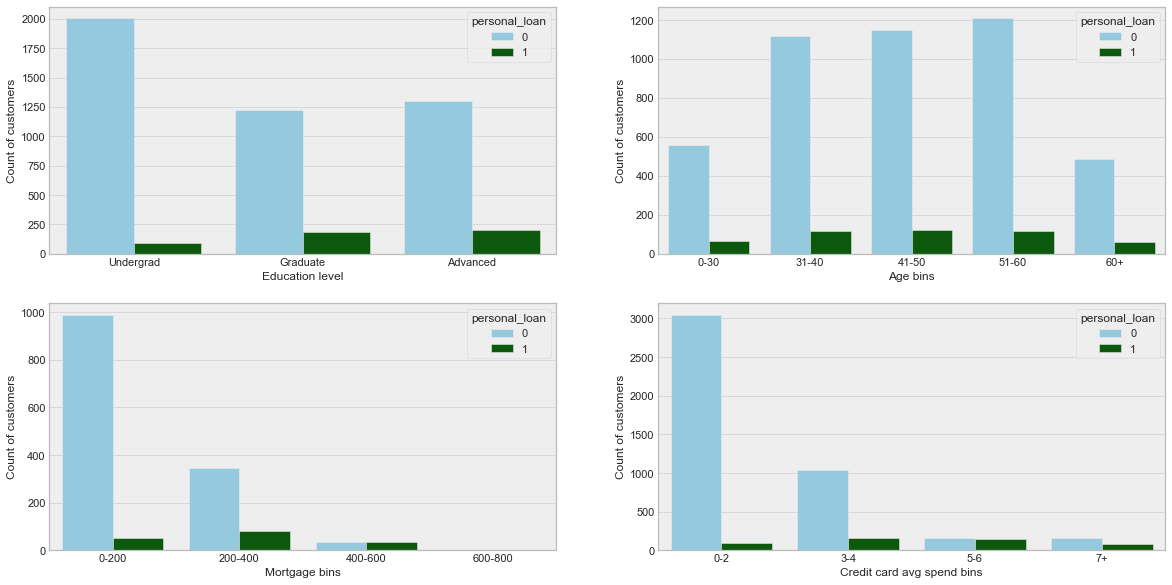

In [12]:
fig, axes = plt.subplots(2, 2, figsize = (20,10))

# Distribution of Education
xx = groupby_get_cc_count(df[["education", "personal_loan"]], "education")
d_dict = {1 : "Undergrad", 2 : "Graduate", 3 : "Advanced"}
xx["degree"] = xx["education"].apply(lambda x : d_dict[x])
ax = sns.barplot(xx["degree"], xx["count"], hue = xx["personal_loan"], ax = axes[0][0], palette= ["skyblue", "darkgreen"]);
ax.set(xlabel = 'Education level', ylabel = 'Count of customers');

# Distribution of Age
df['age_bin'] = pd.cut(df['age'], bins = [0, 30, 40, 50, 60, 100], labels = ['0-30', '31-40', '41-50', '51-60', '60+'])
xx = groupby_get_cc_count(df[["age_bin", "personal_loan"]], "age_bin")
ax = sns.barplot(xx["age_bin"], xx["count"], hue = xx["personal_loan"], ax = axes[0][1], palette= ["skyblue", "darkgreen"]);
ax.set(xlabel = 'Age bins', ylabel = 'Count of customers');

# Distribution of Mortgage
df['mtg_bin'] = pd.cut(df['mortgage'], bins = [0, 200, 400, 600, 800], labels = ['0-200', '200-400', '400-600', '600-800'])
xx = groupby_get_cc_count(df[["mtg_bin", "personal_loan"]], "mtg_bin")
ax = sns.barplot(xx["mtg_bin"], xx["count"], hue = xx["personal_loan"], ax = axes[1][0], palette= ["skyblue", "darkgreen"]);
ax.set(xlabel = 'Mortgage bins', ylabel = 'Count of customers');

# Distribution of CCAvg
df['ccavg_bin'] = pd.cut(df['ccavg'], bins = [0, 2, 4, 6, 100], labels = ['0-2', '3-4', '5-6', '7+'])
xx = groupby_get_cc_count(df[["ccavg_bin", "personal_loan"]], "ccavg_bin")
ax = sns.barplot(xx["ccavg_bin"], xx["count"], hue = xx["personal_loan"], ax = axes[1][1], palette= ["skyblue", "darkgreen"]);
ax.set(xlabel = 'Credit card avg spend bins', ylabel = 'Count of customers');

**Observations:**

- **Education** : Most of the customers are undergraduates. There are more number of customers who have taken a personal_loan and Education level of Advanced followed by Graduates and Undergrads being the lowest which suggests that higher the education level the more the customer is confident and open to opt for **personal_loan**. 

- **Age**: There are a lot of people in the age range of 51-60 but people in the age bracket of 41-50 have the highest number of customers with a personal loan.

- **Mortgage** : Majority of the customers are in the 0-200 mortgage bin but the number of people with personal loan is the highest in the 200-400 bin.

- **CCAvg** : More than 50% of the customers have an average credit card spend in the range of 0-2 but has a very less number of people with personal_loan as compared to other bins. The customers with average credit card spend of 3-4 and 5-6 have a lot of customers who have taken a personal loan

<hr>

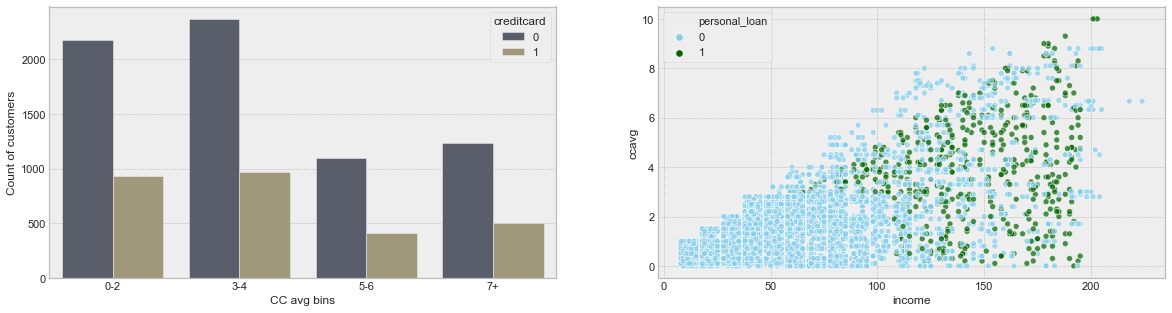

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))

xx = df[["ccavg", "creditcard", "personal_loan"]]
xx['ccavg_bin'] = pd.cut(xx['ccavg'], bins = [0, 2, 4, 6, 100], labels = ['0-2', '3-4', '5-6', '7+'])
xx = xx.groupby(["ccavg_bin", "creditcard"])["ccavg"].sum().reset_index()
sns.barplot(xx["ccavg_bin"], xx["ccavg"], hue = xx["creditcard"], palette= "cividis", ax=axes[0]);
axes[0].set(xlabel = 'CC avg bins', ylabel = 'Count of customers');

sns.scatterplot(x = "income", y = "ccavg", data = df, hue = "personal_loan", ax = axes[1], palette=["skyblue", "darkgreen"], alpha = 0.7);

**Observations:**
    
- There are more number of credit card holders that have an average credit card spend **ccavg** in the range of **3 to 4** than the other bins.
- There are also a sizeable number of customers that are heavy spenders in the **7+ bin**.

<hr>

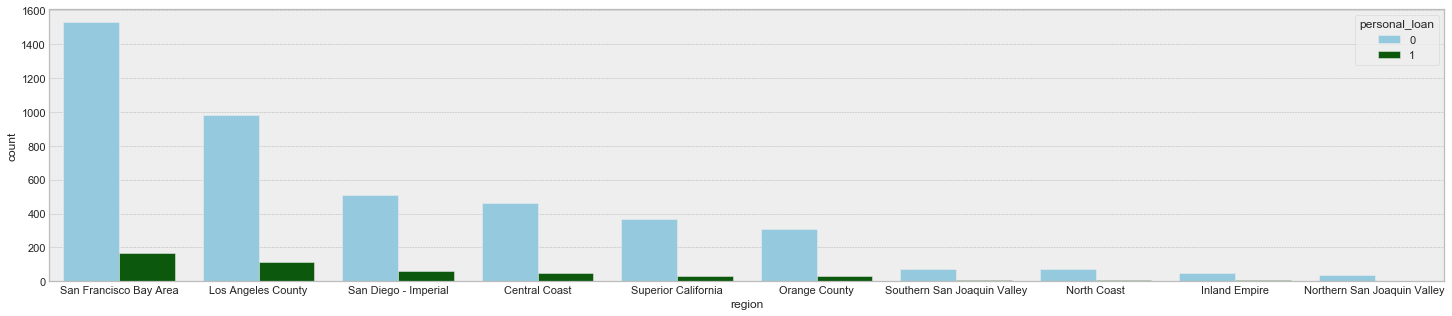

In [14]:
plt.figure(figsize=(25,5))

# Using the uszipcode package, we can get the county for all our zipcodes.
xx = df[["zip_code", "personal_loan"]]
xx["county"] = xx["zip_code"].apply(lambda x : search.by_zipcode(x).county)

def get_region(el):
    kk = None
    for k,v in region_county.items():
        if el in v:
            kk = k
    return kk

xx["region"] = xx["county"].apply(get_region)
xx["personal_loan"] = xx["personal_loan"].astype(str)
xx = groupby_get_cc_count(xx, "region")

xx = xx.sort_values("count", ascending = False)

# Plotting a spider chart for the region column
categories = xx["region"].unique().tolist()
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=xx[xx["personal_loan"] == "0"]["count"], theta=categories, fill='toself', name='No personal loan'))
fig.add_trace(go.Scatterpolar(r=xx[xx["personal_loan"] == "1"]["count"], theta=categories, fill='toself', name='Has personal loan'))
fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 1600])), showlegend=False)
fig.show()

# Distribution of region
sns.barplot(xx["region"], xx["count"], hue=xx["personal_loan"], palette = ["skyblue", "darkgreen"]);

**Observations:**

- The San Fransisco Bay Area has the highest number of customers in total which is almost double that of Los Angeles County even though the population of Los Angeles County is higher than SF Bay.
- San Francisco Bay Area also has the highest number of customers with a personal loan followed by Los Angeles County.

<hr>

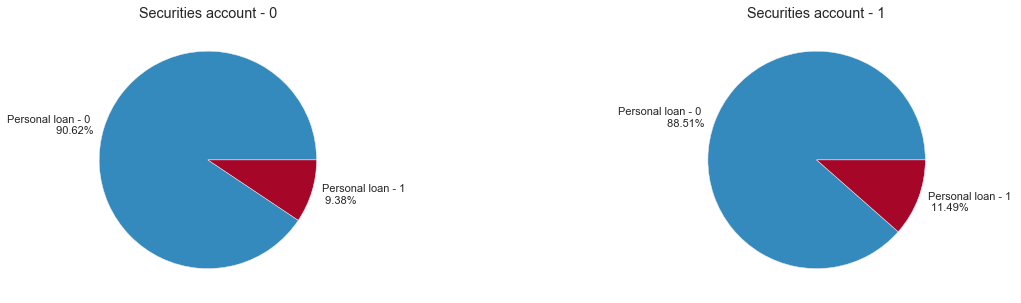

In [15]:
fig, axes = plt.subplots(1,1, figsize=(20, 5))
xx = df[["securities_account", "personal_loan"]]
xx = groupby_get_cc_count(xx, "securities_account")

# Distribution of Securities account
for i in [0,1]:
    temp_xx = xx[xx["securities_account"] == i]
    total = temp_xx["count"].sum()
    pl_0 = round(temp_xx.iloc[0]["count"]/total*100, 2)
    pl_1 = round(temp_xx.iloc[1]["count"]/total*100, 2)
    create_donut(*(i+1, pl_0, pl_1, 2))
    plt.title(f"Securities account - {i}")

**Observations:**

- Majority of people **do not** have a securities account with the bank.
- It is interesting to note that the percentage of people who have taken a personal loan and **have** a securities account is **more than** the percentage of people who have taken a personal loan but **don't have** a securities account.

<hr>

In [16]:
fig, axes = plt.subplots(3, 2, figsize = (20,15))

# Distribution of cd_account
sns.violinplot(x = "cd_account", y = "income", data=df, hue="personal_loan", palette = ["skyblue", "darkgreen"], alpha = 0.5, ax=axes[0][0]);

xx = df[["cd_account", "personal_loan"]]
xx = groupby_get_cc_count(xx, "cd_account")
sns.barplot(x = "cd_account", y = "count", data = xx, hue = "personal_loan", palette = ["skyblue", "darkgreen"], ax = axes[0][1]);


# Distribution of creditcard
sns.violinplot(x = "creditcard", y = "income", data=df, hue="personal_loan", palette = ["skyblue", "darkgreen"], alpha = 0.5, ax=axes[1][0]);

xx = df[["creditcard", "personal_loan"]]
xx = groupby_get_cc_count(xx, "creditcard")
sns.barplot(x = "creditcard", y = "count", data = xx, hue = "personal_loan", palette = ["skyblue", "darkgreen"], ax = axes[1][1]);


# Distribution of online
sns.violinplot(x = "online", y = "income", data=df, hue="personal_loan", palette = ["skyblue", "darkgreen"], alpha = 0.5, ax=axes[2][0]);

xx = df[["online", "personal_loan"]]
xx = groupby_get_cc_count(xx, "online")
sns.barplot(x = "online", y = "count", data = xx, hue = "personal_loan", palette = ["skyblue", "darkgreen"], ax = axes[2][1]);

**Observations**:

- **cd_account**: There a more number of customers who have a **cd_account** at the bank and have taken a **personal_loan** previously. Regardless of whether they have a cd_account or not, majority of them have an **income** of more than **100**.

- **creditcard** : The ratio of customers with creditcard and no creditcard is almost 1:2.

- **online** : It is interesting to note that there many people who use online modes of transactions than people who still go the traditional way and amongst these people, the ones who use online modes of transaction, are more interested in opting for personal_loans maybe because spending money online is easy and tempting.

<hr>

## Distribution of target column

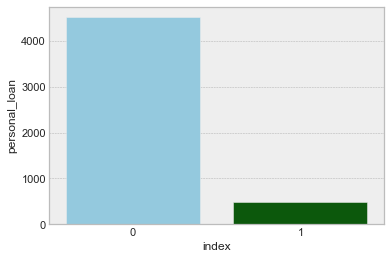

In [17]:
xx = df["personal_loan"].value_counts().reset_index()
sns.barplot(xx["index"], xx["personal_loan"], palette=["skyblue", "darkgreen"]);

- The column **personal_loan** is highly imbalanced where only **15%** of the customers have previously opted for a personal loan in the dataset. 

<hr>

In [18]:
df.drop(columns=["age_bin", "mtg_bin", "ccavg_bin"], inplace=True)

Drop the columns on which we performed manual binning i.e. **age_bin, mtg_bin** and **ccavg_bin**. 

<hr>

Let's get our data ready for training our models on.

In [19]:
df_train = df.drop(columns=["id", "zip_code"])   # Drop id and zip_code since we won't be able to use them to build our model.
target_col = ["personal_loan"]                    
col_names = list(df_train.columns)
col_names.remove(target_col[0])

df_train = df_train[col_names + target_col]      # Send the target column to the end of the dataframe.

## Correlation

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(df_train.corr(), annot=True, fmt='.2g');

Observations: 

- The above correlation heat map shows a high correlation between **age** and **experience**, hence we can drop the **experience** column since it contains negative values.

- Looking at the correlations of other columns with **personal_loan**, we can see that **age**, **experience**, **family**, **securities_account**, **online** and **creditcard** have a very low correlation.

In [21]:
# Dropping a few columns since their correlation with personal_loan is low.
df_train.drop(columns = ["age", "experience", "securities_account", "online", "creditcard"], inplace = True)

## Standardization (Scaling)

In [22]:
std = StandardScaler()

col_names = list(df_train.columns)
col_names.remove("personal_loan")

scaled = std.fit_transform(df_train[col_names])
scaled = pd.DataFrame(scaled, columns=col_names)

df_train = pd.concat([scaled, df_train[target_col]], axis=1)

df_train.head()

income    family     ccavg  education  mortgage  cd_account  \
0 -0.538229  1.397414 -0.193385  -1.049078 -0.555524    -0.25354   
1 -0.864109  0.525991 -0.250611  -1.049078 -0.555524    -0.25354   
2 -1.363793 -1.216855 -0.536736  -1.049078 -0.555524    -0.25354   
3  0.569765 -1.216855  0.436091   0.141703 -0.555524    -0.25354   
4 -0.625130  1.397414 -0.536736   0.141703 -0.555524    -0.25354   

   personal_loan  
0              0  
1              0  
2              0  
3              0  
4              0

## Train and Test split (70:30)

In [23]:
X = df_train[col_names]      # Contains the independent columns 
y = df_train[target_col]     # Our target column

Split the dataset into test and train in 70:30 ratio

In [24]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 29861)
train_y = train_y["personal_loan"]
test_y = test_y["personal_loan"]

## Train models

In [25]:
conf_matrix_all = {}

def personal_loan_prediction(name, algo, training_x, testing_x, training_y, testing_y, plot) :
    algo.fit(training_x,training_y)                           # Fit the training data set to the algorithm passed.
    predictions = algo.predict(testing_x)                     # Get all predictions
    probabilities = algo.predict_proba(testing_x)             # Get probablities of predictions

    conf_matrix = confusion_matrix(testing_y, predictions)    # Get confusion matrix using the predictions
    tn, fp, fn, tp = conf_matrix.ravel()
    
    conf_matrix_all[name] = conf_matrix                       # Save confusion matrix values to a dictionary
    
    print("Classification report:")                           # Print the classification report
    print(classification_report(testing_y, predictions))
  
    model_roc_auc = roc_auc_score(testing_y, predictions)           # Get the Area under the curve number
    fpr,tpr,thresholds = roc_curve(testing_y, probabilities[:,1])   # Get False postive rate and true positive rate
    
    print ("Area under the curve: ", model_roc_auc)
    
    
    if plot:
        fig, axes = plt.subplots(1,2, figsize=(20, 7))
        conf_matrix = np.flip(conf_matrix)
        
        labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
        labels = np.core.defchararray.add(conf_matrix.astype(str), labels)
        sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[0], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);                                           # Plot the confusion matrix
        axes[0].set(xlabel='Predicted', ylabel='Actual')

        plt.title('Receiver Operating Characteristic')
        sns.lineplot(fpr, tpr, ax=axes[1])                                         # Plot the ROC curve
        plt.plot([0, 1], [0, 1],'--')                                              # Plot the diagonal line
        axes[1].set_xlim([0, 1])                                                   # Set x-axis limit to 0 and 1
        axes[1].set_ylim([0, 1])                                                   # Set y-axis limit to 0 and 1
        axes[1].set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate');
        plt.show();

### Logistic Regression

In [26]:
lr  = LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, penalty="l1", solver='liblinear')

personal_loan_prediction("Logistic Regression", lr, train_X, test_X, train_y, test_y, plot = True)

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1357
           1       0.79      0.62      0.70       143

    accuracy                           0.95      1500
   macro avg       0.88      0.80      0.83      1500
weighted avg       0.95      0.95      0.95      1500

Area under the curve:  0.8027142349176248


### K-nearest Neighbors

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1357
           1       0.95      0.94      0.95       143

    accuracy                           0.99      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.99      0.99      0.99      1500

Area under the curve:  0.9694487531628284


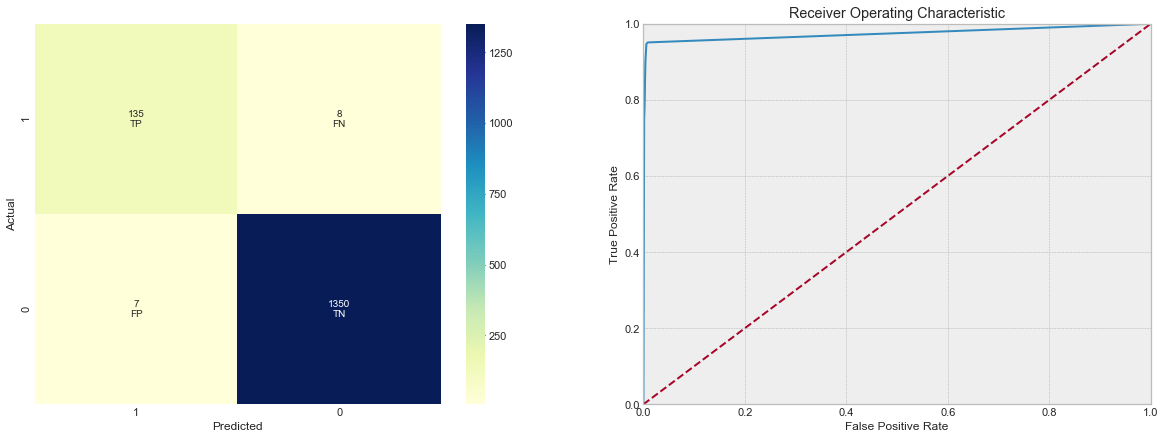

In [27]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', metric_params=None, n_neighbors = 2, weights='distance')

personal_loan_prediction("K-Nearest Neighbours", knn, train_X, test_X, train_y, test_y, plot=True)

### Naïve Bayes

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1357
           1       0.44      0.62      0.51       143

    accuracy                           0.89      1500
   macro avg       0.70      0.77      0.73      1500
weighted avg       0.91      0.89      0.90      1500

Area under the curve:  0.7691843896707568


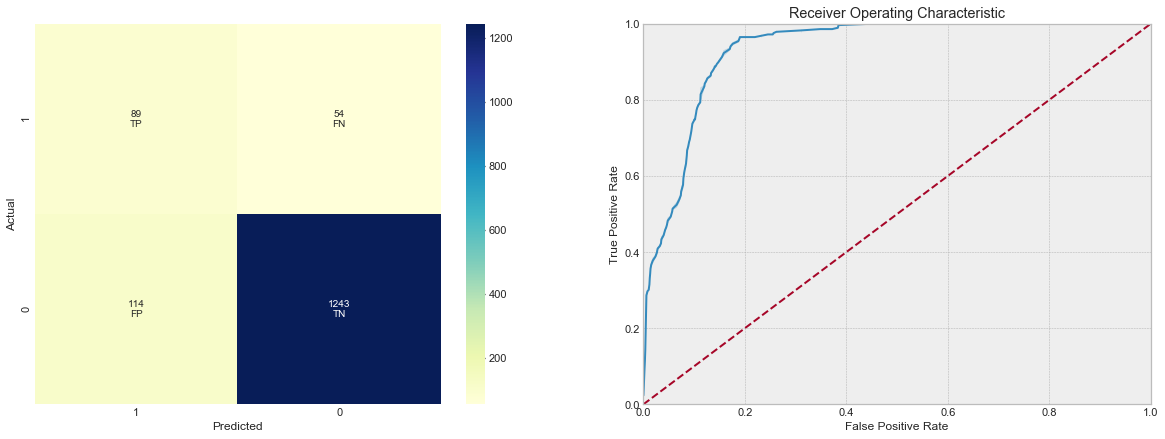

In [28]:
gnb = GaussianNB(priors=None, var_smoothing=1e-09)

personal_loan_prediction("Gaussian Naïve Bayes", gnb, train_X, test_X, train_y, test_y, plot=True)

## Plotting the confusion matrix for all our models

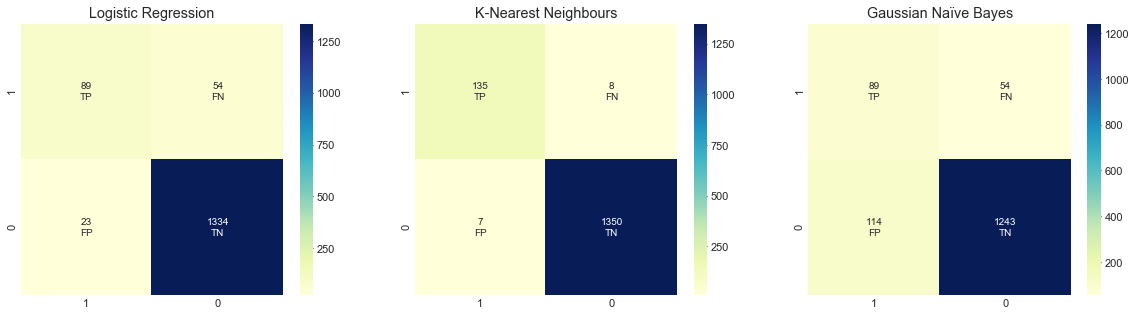

In [29]:
import math
fig, axes = plt.subplots(1,3, figsize = (20, 5))

cnt = 0
for c in range(3):
    try:
        conf_matrix = np.flip(list(conf_matrix_all.values())[cnt])
        labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
        labels = np.core.defchararray.add(conf_matrix.astype(str), labels)

        sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[c], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);
        axes[c].set(title=list(conf_matrix_all.keys())[cnt])
        cnt += 1
    except:
        pass

## The best model?


- Looking at the accurary of all our models, regardless of oversampling or not, the **K-Nearest Neighbors** classifier gives us the best fit for our model but we cannot trust the accuracy metrics alone.
- The **Naïve Bayes** model has the lowest accuracy and AUC for our dataset and is the worst performing model of the lot. The **Logistic Regression** model performs significantly better than **Naïve Bayes**.
- The **Type I** and **Type II** errors are the lowest when it comes to the **KNN algorithm** followed by the **Logistic Regression** model.
- Our **KNN model** also has the highest **True Positive Rates** and hence it shows in the **ROC curve** graph. The **Area under the curve (AUC)** of 0.969 is also the highest for the **KNN model** since the line almost sticks to the upper left corner which is ideal.
- The other metrics such as **Recall** and **F1 score** is also 0.94 and 0.95 respectively for the **KNN model** which is the highest.

#### Hence the model that does the best job at predicting our target column is the K-Nearest Neighbors